In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / "ppi-assembly" / "processed_data"

# Add hcat package to path
sys.path.insert(0, str(BASE_DIR / "cat" / "dcat"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load tree and metadata
clustering_path = DATA_DIR / "clustering" / "disjoint" / "brca_ppi_leiden.csv"
metadata_path = DATA_DIR / "metadata" / "node_to_sequence.json"

clustering_df = pd.read_csv(clustering_path)

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"Clustering loaded: {len(clustering_df)} entries")
print(f"Metadata loaded: {len(metadata)} entries")

Clustering loaded: 2394 entries
Metadata loaded: 2394 entries


In [3]:
import pandas as pd
import json

# Load your metadata JSON
with open(metadata_path, 'r') as f:
    metadata_dict = json.load(f)

# Convert to DataFrame with SPACE-SEPARATED sequences for ProteinBERT
metadata_df = pd.DataFrame([
    {
        'id': int(node_id),
        'title': '',  # Empty title
        'abstract': ' '.join(list(sequence))  # SPACE-SEPARATE the amino acids!
    }
    for node_id, sequence in metadata_dict.items()
])

# Save to CSV
metadata_df.to_csv('metadata.csv', index=False)

metadata_df.head()

,id,title,abstract
0,0,,M G L T V S A L F S R I F G K K Q M R I L M V ...
1,1,,M T A E E M K A T E S G A Q S A P L P M E G V ...
2,2,,M T A E L Q Q D D A A G A A D G H G S S C Q M ...
3,3,,M A A N K P K G Q N S L A L H K V I M V G S G ...
4,4,,M N R G V P F R H L L L V L Q L A L L P A A T ...


In [4]:
# IMPORTANT: Create test split BEFORE training
# This ensures validation and test sets use the same nodes
from notebook_utils import create_test_split

all_node_ids = [str(node_id) for node_id in metadata_df['id'].values]
test_val_nodes = create_test_split(all_node_ids, test_ratio=0.1, seed=42)

print(f"\nTest/Val set: {len(test_val_nodes)} nodes ({len(test_val_nodes)/len(all_node_ids)*100:.1f}%)")
print(f"Train set: {len(all_node_ids) - len(test_val_nodes)} nodes")

metadata_df.head()


Test/Val set: 239 nodes (10.0%)
Train set: 2155 nodes


,id,title,abstract
0,0,,M G L T V S A L F S R I F G K K Q M R I L M V ...
1,1,,M T A E E M K A T E S G A Q S A P L P M E G V ...
2,2,,M T A E L Q Q D D A A G A A D G H G S S C Q M ...
3,3,,M A A N K P K G Q N S L A L H K V I M V G S G ...
4,4,,M N R G V P F R H L L L V L Q L A L L P A A T ...


In [5]:
clustering_df.columns = ['node', 'cluster']
clustering_df.to_csv('reformatted_clustering.csv')

In [7]:
from train import train_model

# Train model with standard triplet loss
# Using test_val_nodes for validation to ensure consistency
finetuned_model, tokenizer, history = train_model(
    clustering_csv_path='reformatted_clustering.csv',
    metadata_csv_path='metadata.csv',
    output_dir=str(BASE_DIR / "cat" / "models" / "finetuned_dcat_esm_triplet"),
    model_name='facebook/esm2_t12_35M_UR50D',
    device=str(device),
    batch_size=16,
    epochs=3,
    lr=1e-5,
    margin=0.1,              # Standard triplet margin
    samples_per_node=3,      
    pooling='cls',
    loss_type='triplet',     # Standard triplet loss (not adaptive)
    val_nodes=test_val_nodes  # Use same nodes for validation as we'll use for testing
)

Using device: cuda

Loading clustering from reformatted_clustering.csv...
Loaded clustering:
  Total nodes: 2394
  Total clusters: 251
  Avg cluster size: 9.5

Loading metadata from metadata.csv...
  Entries: 2394

Loading model: facebook/esm2_t12_35M_UR50D...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating dataset...


Generating triplets: 100%|██████████| 2394/2394 [00:02<00:00, 841.28it/s]


  Generated 7182 triplets
  Using 239 nodes for validation (node-level split)
  Train: 6465 triplets | Val: 717 triplets
  Train nodes: 2155 (approx)
  Val nodes: 239

Configuring loss function...
Loss: TripletLoss
  Margin: 0.1

Starting training for 3 epochs

Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 405/405 [04:04<00:00,  1.65it/s, loss=0.0664, d_pos=0.321, d_neg=0.354]


  Avg d_pos: 0.3047, Avg d_neg: 0.3529, Margin: 0.0482
  Train loss: 0.0738
  Learning rate: 1.00e-05


Evaluating: 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


  Val loss: 0.0639
  ✓ New best! Saving to /home/vikramr2/cat/models/finetuned_dcat_esm_triplet...

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 405/405 [04:05<00:00,  1.65it/s, loss=0.0000, d_pos=0.389, d_neg=0.596]


  Avg d_pos: 0.3556, Avg d_neg: 0.4833, Margin: 0.1277
  Train loss: 0.0413
  Learning rate: 7.75e-06


Evaluating: 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


  Val loss: 0.0512
  ✓ New best! Saving to /home/vikramr2/cat/models/finetuned_dcat_esm_triplet...

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 405/405 [04:04<00:00,  1.65it/s, loss=0.0000, d_pos=0.325, d_neg=0.651]


  Avg d_pos: 0.3969, Avg d_neg: 0.5796, Margin: 0.1827
  Train loss: 0.0246
  Learning rate: 3.25e-06


Evaluating: 100%|██████████| 45/45 [00:11<00:00,  3.86it/s]

  Val loss: 0.0514

Training complete!
  Best val loss: 0.0512
  Model saved to: /home/vikramr2/cat/models/finetuned_dcat_esm_triplet


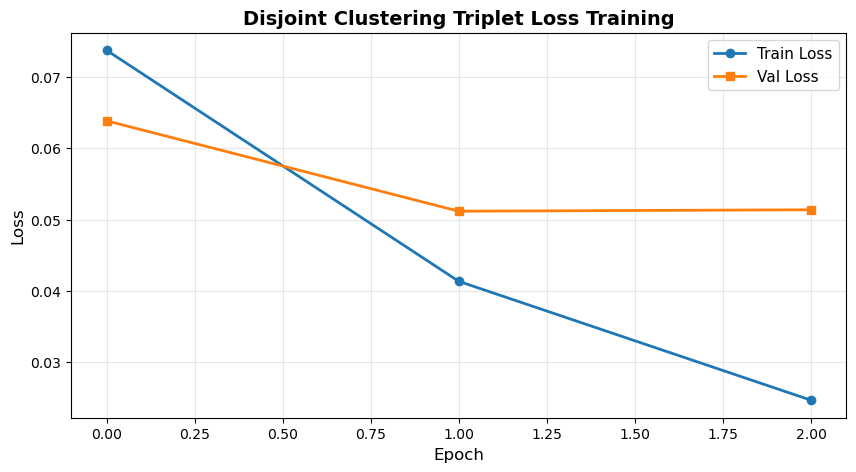


Final train loss: 0.0246
Final val loss: 0.0514


In [8]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], marker='o', label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], marker='s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Disjoint Clustering Triplet Loss Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")

In [9]:
from notebook_utils import compute_embeddings

# Load the BEST saved model (not the final epoch model)
output_dir = BASE_DIR / "cat" / "models" / "finetuned_dcat_esm_triplet"

print("Loading best saved model...")
best_tokenizer = AutoTokenizer.from_pretrained(str(output_dir))
best_model = AutoModel.from_pretrained(str(output_dir)).to(device)
best_model.eval()

print(f"✓ Loaded best model from: {output_dir}")

# Compute embeddings for all nodes using BEST model
print("\nComputing embeddings with best model...")
embeddings_dict = compute_embeddings(
    best_model,  # Use BEST saved model
    best_tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Computed embeddings for {len(embeddings_dict)} nodes")

Loading best saved model...
✓ Loaded best model from: /home/vikramr2/cat/models/finetuned_dcat_esm_triplet

Computing embeddings with best model...
Preparing 2394 documents...


Preparing:   0%|          | 0/2394 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/75 [00:00<?, ?it/s]

✓ Computed embeddings for 2394 nodes
✓ Computed embeddings for 2394 nodes


Evaluating on test set: 239 nodes

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/ppi-assembly/processed_data/network/brca_ppi_edgelist_cleaned.csv
Loaded 53363 edges
Network has 2394 unique nodes
Test nodes with embeddings and edges: 239

Evaluating link prediction with top-k retrieval...
Test nodes: 239
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/239 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 239
Negative samples per positive: 10


Sampling edges:   0%|          | 0/239 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.2552
    Precision Normalized@5: 0.2576
    Recall@5: 0.0395
    Hit Rate@5: 0.5523
  K=10:
    Precision@10: 0.1954
    Precision Normalized@10: 0.2016
    Recall@10: 0.0534
    Hit Rate@10: 0.6067
  K=20:
    Precision@20: 0.1611
    Precision Normalized@20: 0.1788
    Recall@20: 0.0796
    Hit Rate@20: 0.6862
  K=50:
    Precision@50: 0.1221
    Precision Normalized@50: 0.1714
    Recall@50: 0.1287
    Hit Rate@50: 0.7950
  K=100:
    Precision@100: 0.0974
    Precision Normalized@100: 0.2101
    Recall@100: 0.2004
    Hit Rate@100: 0.8787

AUC Metrics:
  AUC-ROC: 0.7625
  AUC-PR: 0.2970



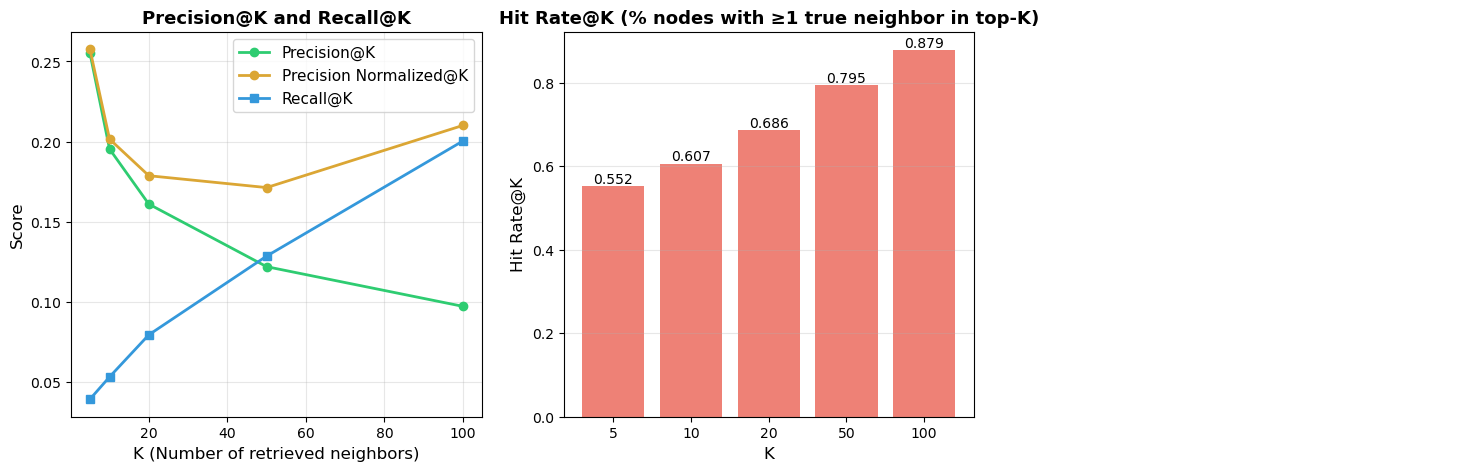

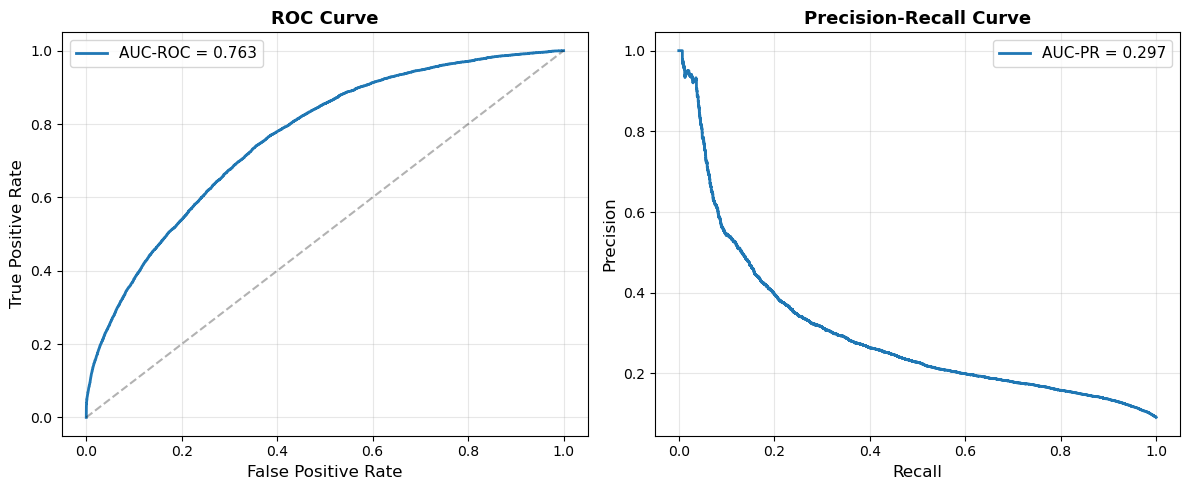

<Figure size 640x480 with 0 Axes>

In [11]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat" / "utils" / "evaluation"))

from link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results
)

edgelist_path = DATA_DIR / "network" / "brca_ppi_edgelist_cleaned.csv"

# Evaluate fine-tuned model using the SAME nodes as validation
print(f"Evaluating on test set: {len(test_val_nodes)} nodes")
results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,  # Same as validation nodes
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(results['topk'], results['auc'])

In [13]:
# Load baseline ESM (not fine-tuned)
print("Loading baseline model...")
baseline_model = AutoModel.from_pretrained('facebook/esm2_t12_35M_UR50D').to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/esm2_t12_35M_UR50D')

# Compute baseline embeddings
print("Computing baseline embeddings...")
baseline_embeddings = compute_embeddings(
    baseline_model,
    tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Baseline embeddings: {len(baseline_embeddings)} nodes")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading baseline model...
Computing baseline embeddings...
Preparing 2394 documents...


Preparing:   0%|          | 0/2394 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/75 [00:00<?, ?it/s]

✓ Computed embeddings for 2394 nodes
✓ Baseline embeddings: 2394 nodes



GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/ppi-assembly/processed_data/network/brca_ppi_edgelist_cleaned.csv
Loaded 53363 edges
Building NetworkKit graph...
Graph has 2394 nodes and 53363 edges
Test nodes with embeddings and in graph: 239

Sampling node pairs (strategy: stratified)...
Sampling from 239 test nodes...


Stratified sampling:   0%|          | 0/239 [00:00<?, ?it/s]

Sampled 20726 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/239 [00:00<?, ?it/s]

Pairs with finite graph distance: 20726

Computing embedding distances (metric: cosine)...

Final pair count: 20726

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.4085 (p=0.0000e+00)
  Pearson correlation: 0.3623 (p=0.0000e+00)

Distance Distribution:
  Distance 1: 4852 pairs, mean emb dist = 0.0760 ± 0.0423
  Distance 2: 6229 pairs, mean emb dist = 0.1088 ± 0.0580
  Distance 3: 6229 pairs, mean emb dist = 0.1340 ± 0.0639
  Distance 4: 3394 pairs, mean emb dist = 0.1366 ± 0.0582
  Distance 5: 22 pairs, mean emb dist = 0.1492 ± 0.0609



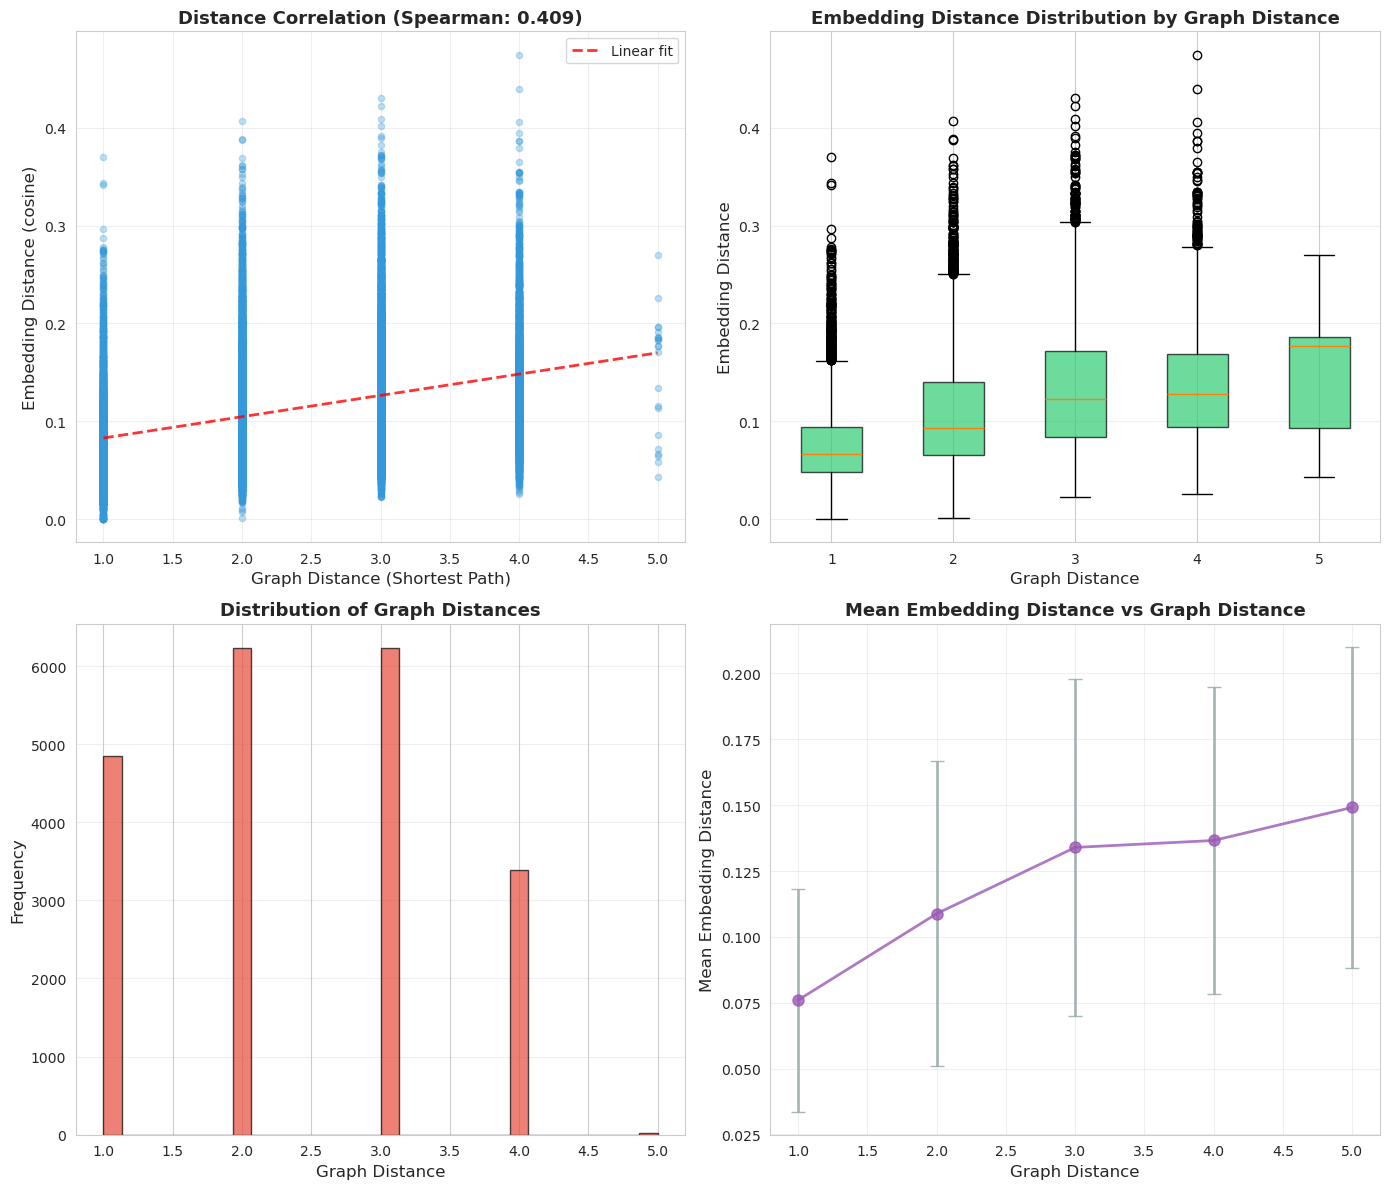

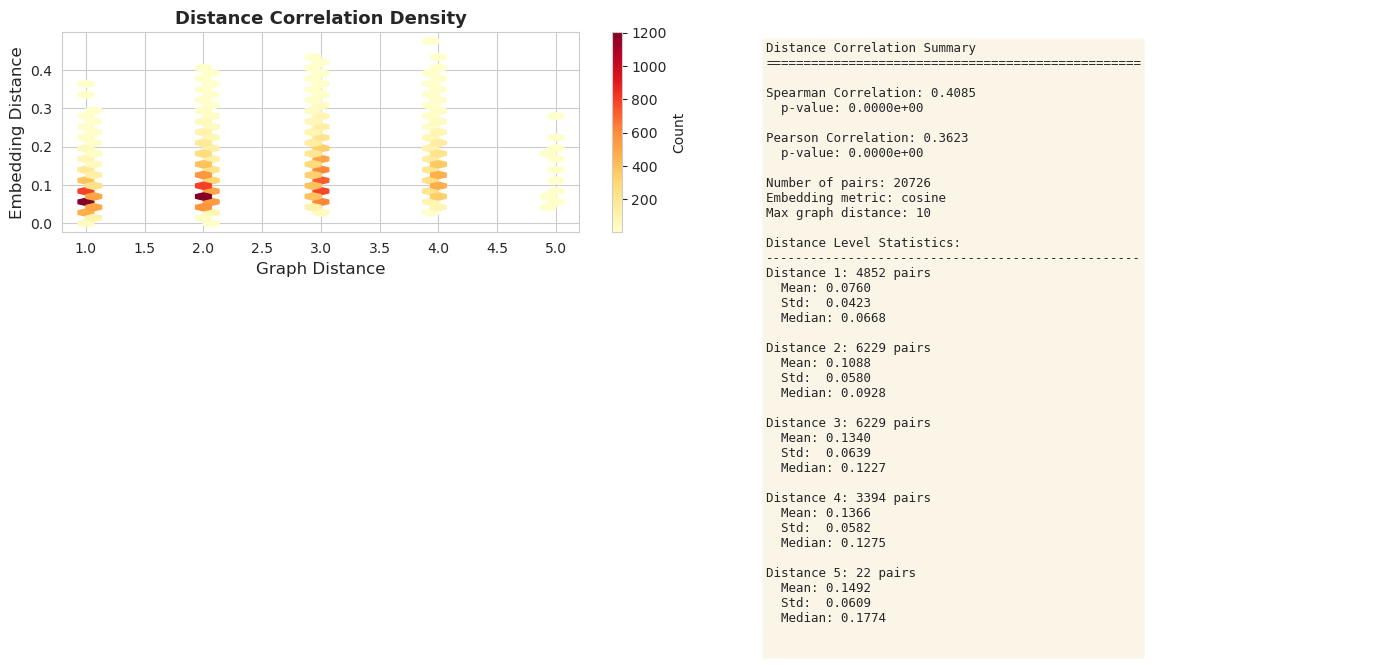

In [16]:
sys.path.insert(0, str(BASE_DIR / "cat" ))

from utils.evaluation.graph_dist_eval import evaluate_distance_correlation, plot_distance_correlation

# Evaluate fine-tuned model
finetuned_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,
    num_samples_per_node=100,
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'
)

plot_distance_correlation(finetuned_distance_evaluation)

In [17]:
# Evaluate clustering structure preservation
from cluster_utils import DisjointClustering
from utils.evaluation.clustering_eval import evaluate_clustering_structure

# Load clustering
clustering = DisjointClustering(clustering_df)

# Evaluate fine-tuned embeddings
finetuned_cluster_results = evaluate_clustering_structure(
    clustering=clustering,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,
    distance_sample_size=2000,
    random_state=42
)

Loaded clustering:
  Total nodes: 2394
  Total clusters: 251
  Avg cluster size: 9.5

               CLUSTERING STRUCTURE EVALUATION

CLUSTER CLASSIFICATION EVALUATION
Cross-validation folds: 5
Evaluating 239 test nodes
  Clusters: 45
  Samples: 239
  Min cluster size: 1
  Max cluster size: 78
  Mean cluster size: 5.3
  Error: smallest cluster has only 1 sample(s)

CLUSTER DISTANCE EVALUATION
Evaluating 239 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.4092 (p=1.31e-81)
Point-biserial correlation: 0.3616 (p=7.90e-63)
Number of pairs evaluated: 2000

Embedding distance statistics:
  Same cluster: 0.0765 ± 0.0333 (394 pairs)
  Diff cluster: 0.1331 ± 0.0626 (1606 pairs)
  Separation ratio: 0.74x

SUMMARY

Cluster Distance Analysis:
  Point-biserial ρ: 0.3616
  Same cluster distance: 0.0765
  Diff cluster distance: 0.1331

